In [1]:
from matplotlib import pyplot as plt
import numpy as np
import importlib

In [2]:
from simulator.ideal import SimulatorIdeal
from simulator.lennard import SimulatorLennard
from simulator.magnetic import SimulatorMagnetic

In [17]:
params = {
    "R" : 1.0,
    "Rz" : 0.01,
    "Bz" : 1.0,
    "eccentricity": 0.1,
    "energy": 1.0,
    "mass": 1.0,
    "sigma":0.4,
    "sigma_grid":0.5,
    "position_random_shift_percentage": 0.0/100,
    "epsilon":0.0,
    "planar": False
}
e = params["eccentricity"]
params.update({
    "abc": np.array(
        [params["R"] / (1-e**2)**(1/4),
        params["R"] * (1-e**2)**(1/4),
        params["Rz"]]
    )
})

In [18]:
sim = SimulatorMagnetic(**params)
r_init, v_init = sim.init_positions_velocities(**params)
sim.particle_number()

21

In [19]:
# history = sim.to_array(sim.simulate(1, dt=1e-5, algorithm="EULER"))
# history = sim.to_array(sim.simulate(1, dt=1e-5, algorithm="RK"))
history = sim.to_array(sim.simulate(1, dt=1e-5, algorithm="VERLET"))

100%|██████████| 99999/99999 [00:30<00:00, 3278.07it/s]


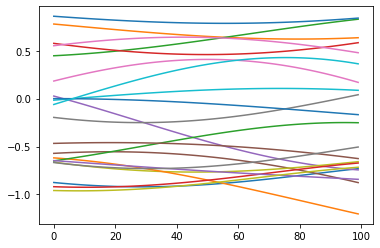

In [20]:
plt.plot(history["L"][:,2,:]);

Text(0.5, 1.0, 'Z Angular Momentum')

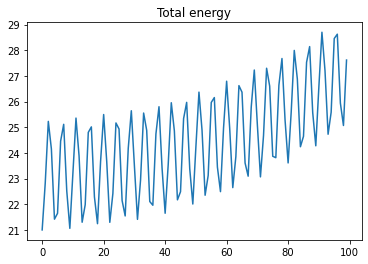

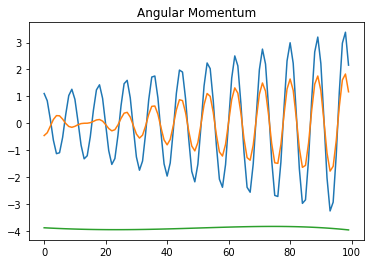

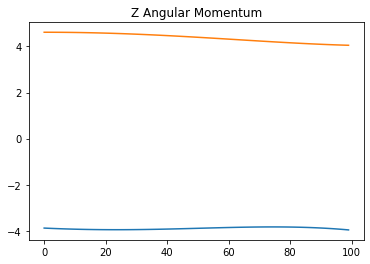

In [22]:
plt.figure()
plt.plot(np.sum(history["KE"] + history["PE"] + 0.5*history["IE"], axis=1))
plt.title("Total energy")
plt.figure()
plt.plot(np.sum(history["L"], axis=2))
plt.title("Angular Momentum")
plt.figure()
plt.plot(np.sum(history["L"][:,2], axis=1))
plt.plot(np.sum(history["L"][:,2] + history["BInertia"], axis=1))
plt.title("Z Angular Momentum")


Text(0.5, 0, 'Z')

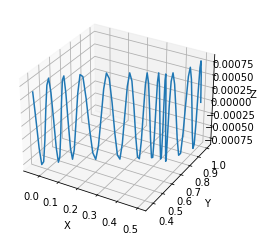

In [9]:
fig = plt.figure()
# ax = fig.gca(projection='3d')
ax = fig.add_subplot(projection='3d')
ax.set_aspect("auto")
pi = 20
rs = history["rs"]
ax.plot(rs[:,0,pi], rs[:,1,pi], rs[:,2,pi])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')